# Trasfer learning model

In [1]:
# !pip install seaborn

In [2]:
import numpy as np
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from sklearn.metrics import classification_report

## Dataset

In [3]:
dataset_path = os.path.join('../../Brain Tumor Data Set')
dataset = tf.keras.utils.image_dataset_from_directory(dataset_path)

dataset

Found 4600 files belonging to 2 classes.


<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [4]:
class_names = np.array(dataset.class_names)
print(class_names)

['Brain Tumor' 'Healthy']


### Train - test split

In [5]:
ds_train = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset='training',
    seed=404,
    batch_size=128
)

Found 4600 files belonging to 2 classes.
Using 3680 files for training.


In [6]:
ds_val = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset='validation',
    seed=404,
    batch_size=128
)

Found 4600 files belonging to 2 classes.
Using 920 files for validation.


In [7]:
for image_batch, labels_batch in ds_train:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(128, 256, 256, 3)
(128,)


## Mobilenet_v2 - simple model

In [8]:
input_shape = (224, 224, 3)

In [9]:
resizer = lambda x, y: (tf.image.resize(x, input_shape[:2]), y)

ds_train_reshaped = ds_train.map(resizer)
ds_val_reshaped = ds_val.map(resizer)

In [10]:
for image_batch, labels_batch in ds_train_reshaped:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(128, 224, 224, 3)
(128,)


In [11]:
base_model = keras.applications.mobilenet_v2.MobileNetV2(
    weights='imagenet',
    input_shape=input_shape,
    include_top=False
)

base_model.trainable = False

model_1 = tf.keras.Sequential(
    [
        keras.layers.Input(input_shape, dtype=tf.float32),
        base_model,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(1)
    ],
    name='mobilenet_simple'
)

model_1.summary()

Model: "mobilenet_simple"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [12]:
model_1.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [13]:
epochs = 100
patience = 2

In [14]:
history_1 = model_1.fit(
    ds_train_reshaped,
    epochs=epochs,
    validation_data=ds_val_reshaped,
    callbacks=[keras.callbacks.EarlyStopping(patience=patience)]
)

Epoch 1/100
29/29 [==============================] - 228s 8s/step - loss: 0.6149 - binary_accuracy: 0.6177 - val_loss: 0.5089 - val_binary_accuracy: 0.6772
Epoch 2/100
29/29 [==============================] - 240s 8s/step - loss: 0.4416 - binary_accuracy: 0.7755 - val_loss: 0.4117 - val_binary_accuracy: 0.7772
Epoch 3/100
29/29 [==============================] - 193s 6s/step - loss: 0.3744 - binary_accuracy: 0.8185 - val_loss: 0.3664 - val_binary_accuracy: 0.8043
Epoch 4/100
29/29 [==============================] - 189s 6s/step - loss: 0.3392 - binary_accuracy: 0.8432 - val_loss: 0.3391 - val_binary_accuracy: 0.8359
Epoch 5/100
29/29 [==============================] - 188s 6s/step - loss: 0.3165 - binary_accuracy: 0.8609 - val_loss: 0.3211 - val_binary_accuracy: 0.8543
Epoch 6/100
29/29 [==============================] - 188s 6s/step - loss: 0.3013 - binary_accuracy: 0.8663 - val_loss: 0.3070 - val_binary_accuracy: 0.8609
Epoch 7/100
29/29 [==============================] - 187s 6s/ste

In [15]:
history_1.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

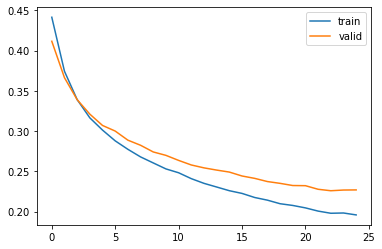

In [16]:
plt.plot(history_1.history['loss'][1:])
plt.plot(history_1.history['val_loss'][1:])
plt.legend(['train', 'valid'])
plt.show();

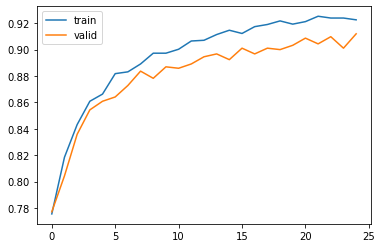

In [17]:
plt.plot(history_1.history['binary_accuracy'][1:])
plt.plot(history_1.history['val_binary_accuracy'][1:])
plt.legend(['train', 'valid'])
plt.show();

### Classification accuracy

In [18]:
x_val_1, y_val_1 = list(tfds.as_numpy(ds_val_reshaped))[0]
y_pred_1 = model_1.predict(x_val_1)
sum((y_pred_1[:, 0] > 0) == y_val_1) / len(y_val_1)

0.859375

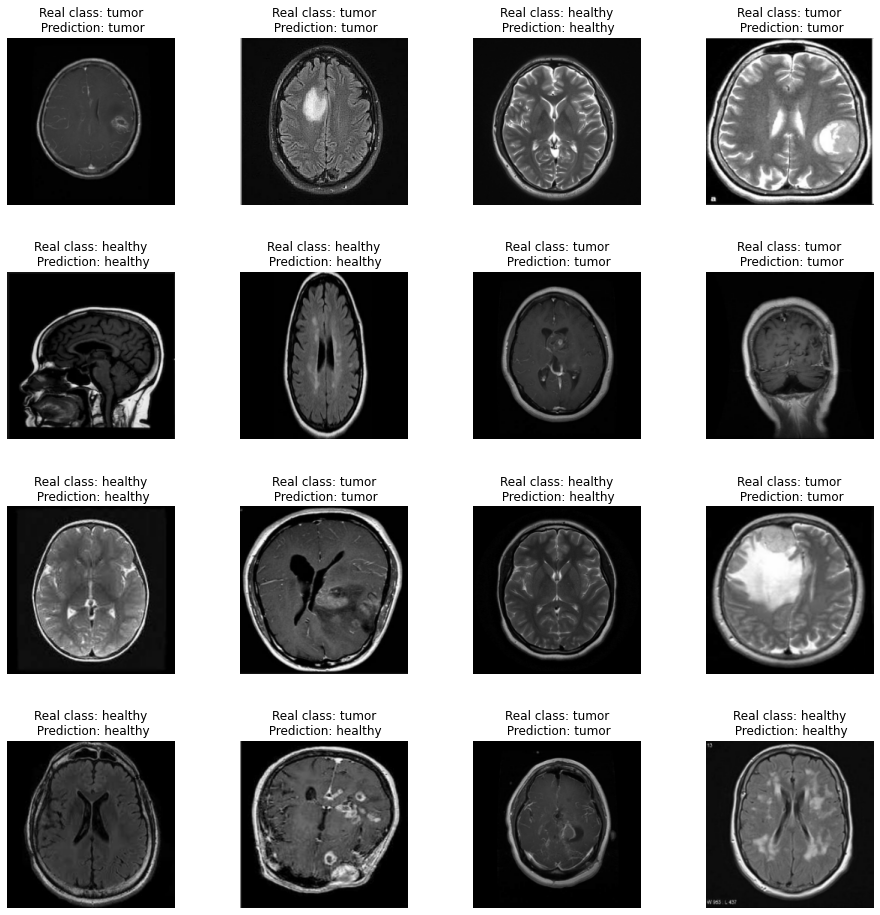

In [19]:
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.4, wspace=.2)

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_val_1[i].astype('int32'))
    
    real_y = 'healthy' if y_val_1[i] == 1 else 'tumor'
    pred_y = 'healthy' if y_pred_1[i] > 0 else 'tumor'
    
    plt.title(f'Real class: {real_y}\n Prediction: {pred_y}')
    plt.axis('off')
plt.show();

In [20]:
y_pred_1_binary = [1 if y > 0 else 0 for y in y_pred_1]

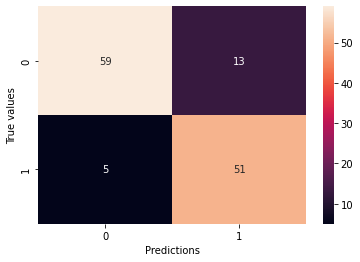

In [21]:
cf = tf.math.confusion_matrix(y_val_1, y_pred_1_binary, dtype=tf.dtypes.int32)
sns.heatmap(cf, annot=True)
plt.xlabel('Predictions')
plt.ylabel('True values')
plt.show();

In [22]:
print(classification_report(y_val_1, y_pred_1_binary, target_names=class_names))

              precision    recall  f1-score   support

 Brain Tumor       0.92      0.82      0.87        72
     Healthy       0.80      0.91      0.85        56

    accuracy                           0.86       128
   macro avg       0.86      0.87      0.86       128
weighted avg       0.87      0.86      0.86       128



## Mobilenet_v2 - model with data augmentation

In [23]:
input_shape = (224, 224, 3)

In [24]:
base_model = keras.applications.mobilenet_v2.MobileNetV2(
    weights='imagenet',
    input_shape=input_shape,
    include_top=False
)

base_model.trainable = False

model_2 = tf.keras.Sequential(
    [
        keras.layers.Input(input_shape, dtype=tf.float32),
        keras.layers.RandomContrast((0.1, 0.6), seed=404),
        keras.layers.RandomTranslation(0.2, 0.2, fill_mode='nearest', seed=404),
        base_model,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(1)
    ],
    name='mobilenet_with_augmentation'
)

model_2.summary()

Model: "mobilenet_with_augmentation"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_contrast (RandomContr (None, 224, 224, 3)       0         
_________________________________________________________________
random_translation (RandomTr (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [25]:
model_2.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [26]:
epochs = 100
patience = 2

In [27]:
history_2 = model_2.fit(
    ds_train_reshaped,
    epochs=epochs,
    validation_data=ds_val_reshaped,
    callbacks=[keras.callbacks.EarlyStopping(patience=patience)]
)

Epoch 1/100
29/29 [==============================] - 266s 9s/step - loss: 0.6563 - binary_accuracy: 0.6000 - val_loss: 0.5924 - val_binary_accuracy: 0.6380
Epoch 2/100
29/29 [==============================] - 244s 8s/step - loss: 0.5465 - binary_accuracy: 0.6916 - val_loss: 0.5385 - val_binary_accuracy: 0.7489
Epoch 3/100
29/29 [==============================] - 249s 8s/step - loss: 0.5055 - binary_accuracy: 0.7285 - val_loss: 0.5000 - val_binary_accuracy: 0.7087
Epoch 4/100
29/29 [==============================] - 252s 9s/step - loss: 0.4758 - binary_accuracy: 0.7571 - val_loss: 0.4679 - val_binary_accuracy: 0.7641
Epoch 5/100
29/29 [==============================] - 301s 10s/step - loss: 0.4400 - binary_accuracy: 0.7796 - val_loss: 0.4490 - val_binary_accuracy: 0.7685
Epoch 6/100
29/29 [==============================] - 312s 11s/step - loss: 0.4377 - binary_accuracy: 0.7742 - val_loss: 0.4345 - val_binary_accuracy: 0.7772
Epoch 7/100
29/29 [==============================] - 302s 10s/

In [28]:
history_2.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

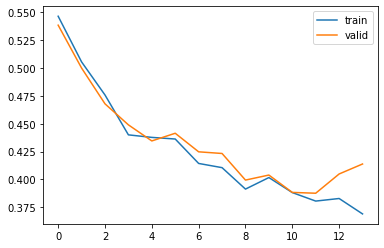

In [29]:
plt.plot(history_2.history['loss'][1:])
plt.plot(history_2.history['val_loss'][1:])
plt.legend(['train', 'valid'])
plt.show();

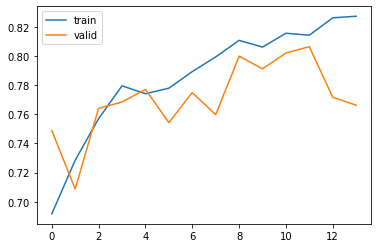

In [30]:
plt.plot(history_2.history['binary_accuracy'][1:])
plt.plot(history_2.history['val_binary_accuracy'][1:])
plt.legend(['train', 'valid'])
plt.show();

### Classification accuracy

In [31]:
x_val_2, y_val_2 = list(tfds.as_numpy(ds_val_reshaped))[0]
y_pred_2 = model_2.predict(x_val_2)
sum((y_pred_2[:, 0] > 0) == y_val_2) / len(y_val_2)

0.8515625

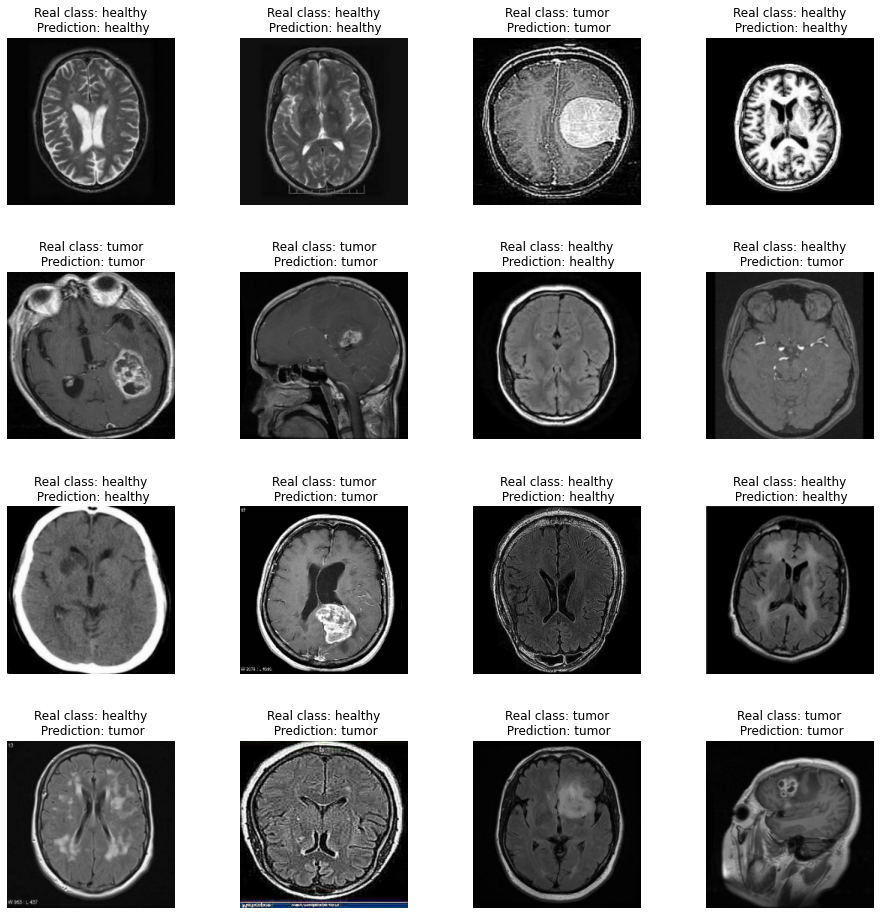

In [32]:
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.4, wspace=.2)

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_val_2[i].astype('int32'))
    
    real_y = 'healthy' if y_val_2[i] == 1 else 'tumor'
    pred_y = 'healthy' if y_pred_2[i] > 0 else 'tumor'
    
    plt.title(f'Real class: {real_y}\n Prediction: {pred_y}')
    plt.axis('off')

plt.show();

In [33]:
y_pred_2_binary = [1 if y > 0 else 0 for y in y_pred_2]

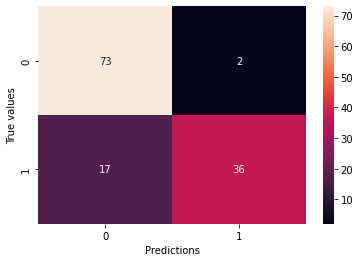

In [34]:
cf = tf.math.confusion_matrix(y_val_2, y_pred_2_binary, dtype=tf.dtypes.int32)
sns.heatmap(cf, annot=True)
plt.xlabel('Predictions')
plt.ylabel('True values')
plt.show();

In [35]:
print(classification_report(y_val_2, y_pred_2_binary, target_names=class_names))

              precision    recall  f1-score   support

 Brain Tumor       0.81      0.97      0.88        75
     Healthy       0.95      0.68      0.79        53

    accuracy                           0.85       128
   macro avg       0.88      0.83      0.84       128
weighted avg       0.87      0.85      0.85       128



## Mobilenet_v2 - model with data augmentation + additional dense layer

In [36]:
input_shape = (224, 224, 3)

In [37]:
base_model = keras.applications.mobilenet_v2.MobileNetV2(
    weights='imagenet',
    input_shape=input_shape,
    include_top=False
)

base_model.trainable = False

model_3 = tf.keras.Sequential(
    [
        keras.layers.Input(input_shape, dtype=tf.float32),
        keras.layers.RandomContrast((0.1, 0.6), seed=404),
        keras.layers.RandomTranslation(0.2, 0.2, fill_mode='nearest', seed=404),
        base_model,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(320),
        keras.layers.Dropout(0.25, seed=404),
        keras.layers.Dense(1)
    ],
    name='mobilenet_with_additional_dense'
)

model_3.summary()

Model: "mobilenet_with_additional_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_contrast_1 (RandomCon (None, 224, 224, 3)       0         
_________________________________________________________________
random_translation_1 (Random (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 320)               409920    
_________________________________________________________________
dropout (Dropout)            (None, 320)               0         
_________________________________________________________________
dense_3 (Dense)              (None,

In [38]:
model_3.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [39]:
epochs = 100
patience = 5

In [40]:
history_3 = model_3.fit(
    ds_train_reshaped,
    epochs=epochs,
    validation_data=ds_val_reshaped,
    callbacks=[keras.callbacks.EarlyStopping(patience=patience)]
)

Epoch 1/100
29/29 [==============================] - 299s 10s/step - loss: 1.3826 - binary_accuracy: 0.6133 - val_loss: 0.8621 - val_binary_accuracy: 0.6870
Epoch 2/100
29/29 [==============================] - 287s 10s/step - loss: 0.4850 - binary_accuracy: 0.7829 - val_loss: 0.4319 - val_binary_accuracy: 0.7620
Epoch 3/100
29/29 [==============================] - 283s 10s/step - loss: 0.4370 - binary_accuracy: 0.7872 - val_loss: 0.4167 - val_binary_accuracy: 0.7750
Epoch 4/100
29/29 [==============================] - 285s 10s/step - loss: 0.3925 - binary_accuracy: 0.8220 - val_loss: 0.5307 - val_binary_accuracy: 0.7098
Epoch 5/100
29/29 [==============================] - 281s 9s/step - loss: 0.3952 - binary_accuracy: 0.8090 - val_loss: 0.3701 - val_binary_accuracy: 0.8109
Epoch 6/100
29/29 [==============================] - 285s 10s/step - loss: 0.4199 - binary_accuracy: 0.8152 - val_loss: 0.3322 - val_binary_accuracy: 0.8478
Epoch 7/100
29/29 [==============================] - 290s 1

In [41]:
history_3.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

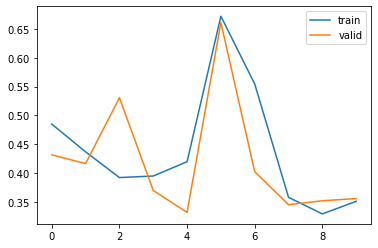

In [42]:
plt.plot(history_3.history['loss'][1:])
plt.plot(history_3.history['val_loss'][1:])
plt.legend(['train', 'valid'])
plt.show();

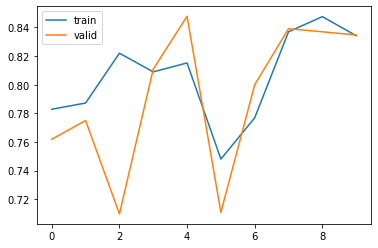

In [43]:
plt.plot(history_3.history['binary_accuracy'][1:])
plt.plot(history_3.history['val_binary_accuracy'][1:])
plt.legend(['train', 'valid'])
plt.show();

### Classification accuracy

In [44]:
x_val_3, y_val_3 = list(tfds.as_numpy(ds_val_reshaped))[0]
y_pred_3 = model_3.predict(x_val_3)
sum((y_pred_3[:, 0] > 0) == y_val_3) / len(y_val_3)

0.8125

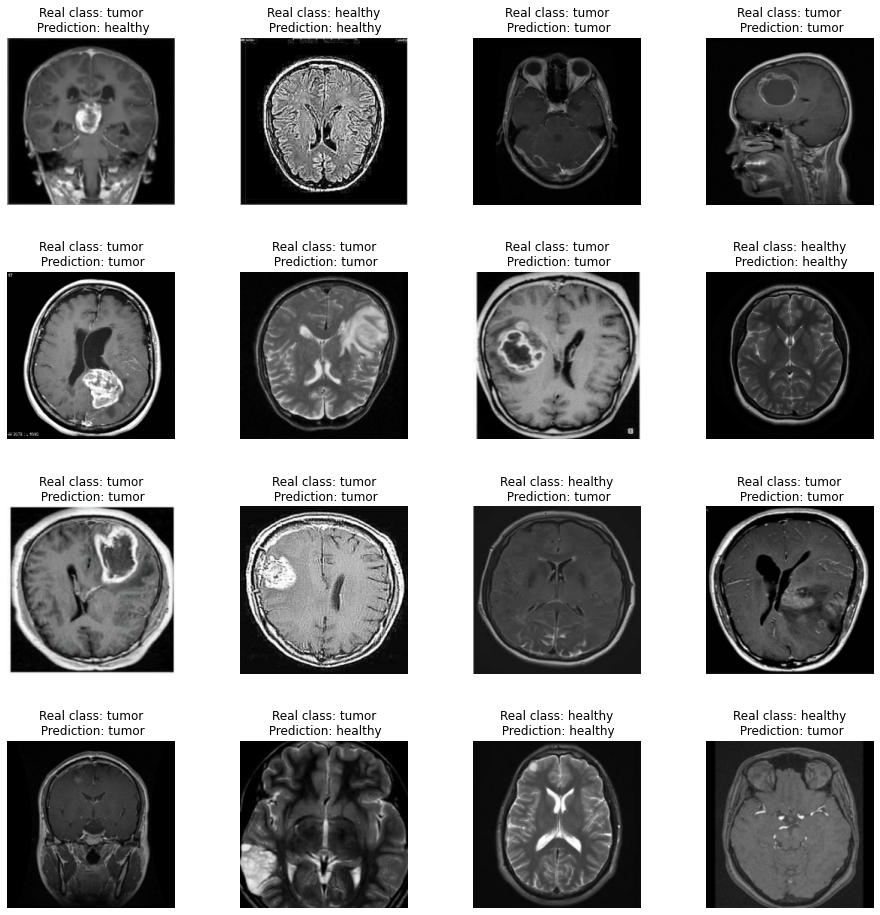

In [45]:
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.4, wspace=.2)

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_val_3[i].astype('int32'))
    
    real_y = 'healthy' if y_val_3[i] == 1 else 'tumor'
    pred_y = 'healthy' if y_pred_3[i] > 0 else 'tumor'
    
    plt.title(f'Real class: {real_y}\n Prediction: {pred_y}')
    plt.axis('off')

plt.show();

In [46]:
y_pred_3_binary = [1 if y > 0 else 0 for y in y_pred_3]

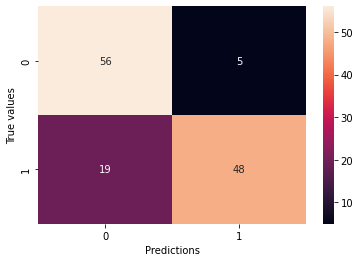

In [47]:
cf = tf.math.confusion_matrix(y_val_3, y_pred_3_binary, dtype=tf.dtypes.int32)
sns.heatmap(cf, annot=True)
plt.xlabel('Predictions')
plt.ylabel('True values')
plt.show();

In [48]:
print(classification_report(y_val_3, y_pred_3_binary, target_names=class_names))

              precision    recall  f1-score   support

 Brain Tumor       0.75      0.92      0.82        61
     Healthy       0.91      0.72      0.80        67

    accuracy                           0.81       128
   macro avg       0.83      0.82      0.81       128
weighted avg       0.83      0.81      0.81       128



## Inception_v3 - simple model

In [49]:
input_shape = (256, 256, 3)

In [50]:
base_model = tf.keras.applications.inception_v3.InceptionV3(
    weights='imagenet',
    input_shape=input_shape,
    include_top=False
)

base_model.trainable = False

model_4 = tf.keras.Sequential(
    [
        base_model,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(1)
    ],
    name='simple_inception'
)

model_4.summary()

Model: "simple_inception"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [51]:
model_4.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [52]:
epochs = 100
patience = 5

In [53]:
history_4 = model_4.fit(
    ds_train,
    epochs=epochs,
    validation_data=ds_val,
    callbacks=[keras.callbacks.EarlyStopping(patience=patience)]
)

Epoch 1/100
29/29 [==============================] - 853s 28s/step - loss: 1.6539 - binary_accuracy: 0.6033 - val_loss: 1.1492 - val_binary_accuracy: 0.6674
Epoch 2/100
29/29 [==============================] - 709s 24s/step - loss: 0.9956 - binary_accuracy: 0.6954 - val_loss: 0.9527 - val_binary_accuracy: 0.7022
Epoch 3/100
29/29 [==============================] - 707s 24s/step - loss: 0.7373 - binary_accuracy: 0.7378 - val_loss: 0.7095 - val_binary_accuracy: 0.7500
Epoch 4/100
29/29 [==============================] - 697s 24s/step - loss: 0.7090 - binary_accuracy: 0.7486 - val_loss: 0.5956 - val_binary_accuracy: 0.7902
Epoch 5/100
29/29 [==============================] - 707s 24s/step - loss: 0.5537 - binary_accuracy: 0.7932 - val_loss: 0.5396 - val_binary_accuracy: 0.8011
Epoch 6/100
29/29 [==============================] - 711s 25s/step - loss: 0.5353 - binary_accuracy: 0.7976 - val_loss: 0.5186 - val_binary_accuracy: 0.8163
Epoch 7/100
29/29 [==============================] - 708s 

In [54]:
history_4.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

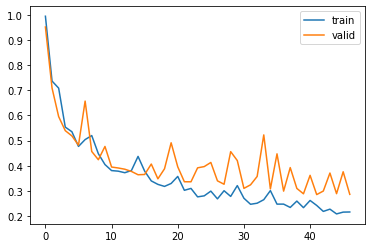

In [55]:
plt.plot(history_4.history['loss'][1:])
plt.plot(history_4.history['val_loss'][1:])
plt.legend(['train', 'valid'])
plt.show();

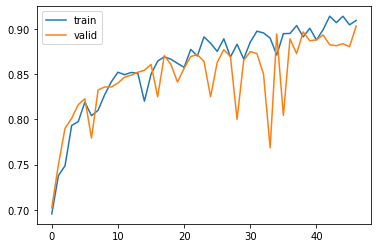

In [56]:
plt.plot(history_4.history['binary_accuracy'][1:])
plt.plot(history_4.history['val_binary_accuracy'][1:])
plt.legend(['train', 'valid'])
plt.show();

### Classification accuracy

In [57]:
x_val_4, y_val_4 = list(tfds.as_numpy(ds_val))[0]
y_pred_4 = model_4.predict(x_val_4)
sum((y_pred_4[:, 0] > 0) == y_val_4) / len(y_val_4)

0.9140625

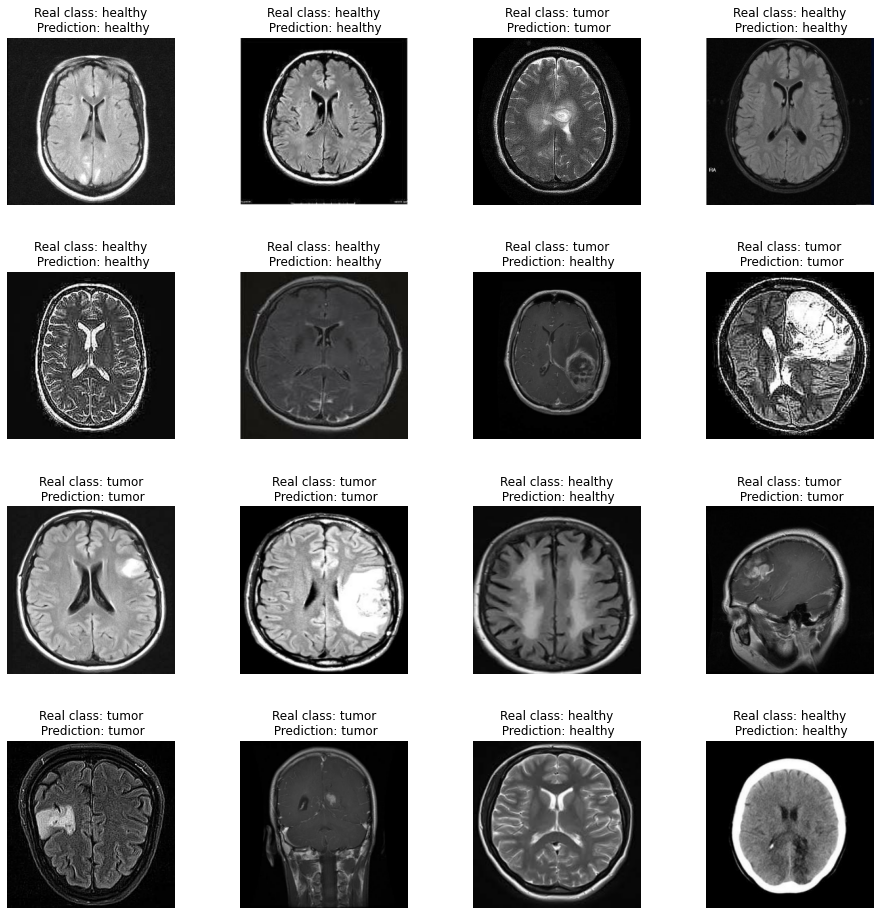

In [58]:
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.4, wspace=.2)

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_val_4[i].astype('int32'))
    
    real_y = 'healthy' if y_val_4[i] == 1 else 'tumor'
    pred_y = 'healthy' if y_pred_4[i] > 0 else 'tumor'
    
    plt.title(f'Real class: {real_y}\n Prediction: {pred_y}')
    plt.axis('off')

plt.show();

In [59]:
y_pred_4_binary = [1 if y > 0 else 0 for y in y_pred_4]

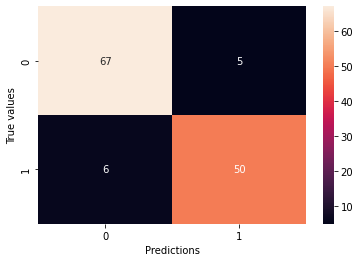

In [60]:
cf = tf.math.confusion_matrix(y_val_4, y_pred_4_binary, dtype=tf.dtypes.int32)
sns.heatmap(cf, annot=True)
plt.xlabel('Predictions')
plt.ylabel('True values')
plt.show();

In [61]:
print(classification_report(y_val_4, y_pred_4_binary, target_names=class_names))

              precision    recall  f1-score   support

 Brain Tumor       0.92      0.93      0.92        72
     Healthy       0.91      0.89      0.90        56

    accuracy                           0.91       128
   macro avg       0.91      0.91      0.91       128
weighted avg       0.91      0.91      0.91       128



## Inception_v3 model - with data augmentation

In [62]:
input_shape = (256, 256, 3)

In [63]:
base_model = keras.applications.inception_v3.InceptionV3(
    weights='imagenet',
    input_shape=input_shape,
    include_top=False
)

base_model.trainable = False

model_5 = tf.keras.Sequential(
    [
        keras.layers.Input(input_shape, dtype=tf.float32),
        keras.layers.RandomContrast((0.1, 0.6), seed=404),
        keras.layers.RandomTranslation(0.2, 0.2, fill_mode='nearest', seed=404),
        base_model,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(1)
    ],
    name='inception_with_augmentation'
)

model_5.summary()

Model: "inception_with_augmentation"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_contrast_2 (RandomCon (None, 256, 256, 3)       0         
_________________________________________________________________
random_translation_2 (Random (None, 256, 256, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [64]:
model_5.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [65]:
epochs = 100
patience = 5

In [66]:
history_5 = model_5.fit(
    ds_train,
    epochs=epochs,
    validation_data=ds_val,
    callbacks=[keras.callbacks.EarlyStopping(patience=patience)]
)

Epoch 1/100
29/29 [==============================] - 528s 18s/step - loss: 2.4235 - binary_accuracy: 0.5864 - val_loss: 1.4419 - val_binary_accuracy: 0.6598
Epoch 2/100
29/29 [==============================] - 525s 18s/step - loss: 1.5351 - binary_accuracy: 0.6299 - val_loss: 0.9892 - val_binary_accuracy: 0.7043
Epoch 3/100
29/29 [==============================] - 534s 18s/step - loss: 1.1667 - binary_accuracy: 0.6685 - val_loss: 1.0380 - val_binary_accuracy: 0.6609
Epoch 4/100
29/29 [==============================] - 536s 18s/step - loss: 1.2482 - binary_accuracy: 0.6538 - val_loss: 0.8443 - val_binary_accuracy: 0.7043
Epoch 5/100
29/29 [==============================] - 539s 19s/step - loss: 0.9651 - binary_accuracy: 0.6826 - val_loss: 0.7440 - val_binary_accuracy: 0.7315
Epoch 6/100
29/29 [==============================] - 531s 18s/step - loss: 0.9016 - binary_accuracy: 0.7014 - val_loss: 0.7947 - val_binary_accuracy: 0.7011
Epoch 7/100
29/29 [==============================] - 544s 

In [67]:
history_5.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

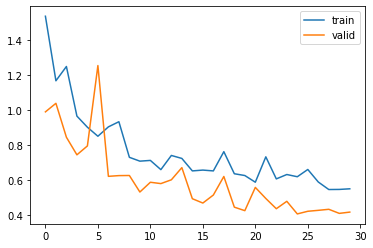

In [68]:
plt.plot(history_5.history['loss'][1:])
plt.plot(history_5.history['val_loss'][1:])
plt.legend(['train', 'valid'])
plt.show();

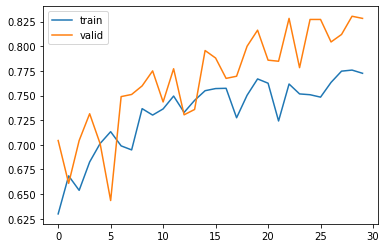

In [69]:
plt.plot(history_5.history['binary_accuracy'][1:])
plt.plot(history_5.history['val_binary_accuracy'][1:])
plt.legend(['train', 'valid'])
plt.show();

### Classification accuracy

In [70]:
x_val_5, y_val_5 = list(tfds.as_numpy(ds_val))[0]
y_pred_5 = model_5.predict(x_val_5)
sum((y_pred_5[:, 0] > 0) == y_val_5) / len(y_val_5)

0.75

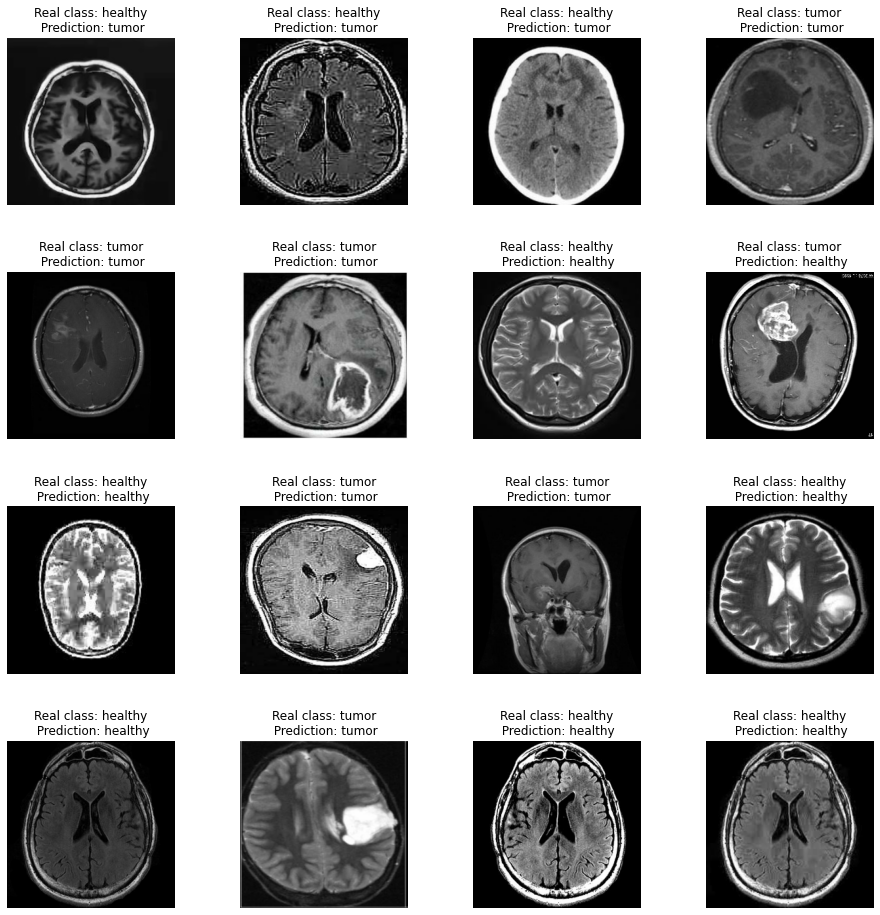

In [71]:
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.4, wspace=.2)

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_val_5[i].astype('int32'))
    
    real_y = 'healthy' if y_val_5[i] == 1 else 'tumor'
    pred_y = 'healthy' if y_pred_5[i] > 0 else 'tumor'
    
    plt.title(f'Real class: {real_y}\n Prediction: {pred_y}')
    plt.axis('off')

plt.show();

In [72]:
y_pred_5_binary = [1 if y > 0 else 0 for y in y_pred_5]

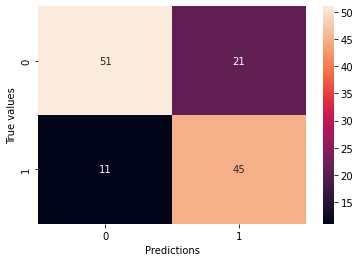

In [73]:
cf = tf.math.confusion_matrix(y_val_5, y_pred_5_binary, dtype=tf.dtypes.int32)
sns.heatmap(cf, annot=True)
plt.xlabel('Predictions')
plt.ylabel('True values')
plt.show();

In [74]:
print(classification_report(y_val_5, y_pred_5_binary, target_names=class_names))

              precision    recall  f1-score   support

 Brain Tumor       0.82      0.71      0.76        72
     Healthy       0.68      0.80      0.74        56

    accuracy                           0.75       128
   macro avg       0.75      0.76      0.75       128
weighted avg       0.76      0.75      0.75       128



## Inception_v3 - model with data augmentation + additional dense layer

In [75]:
input_shape = (256, 256, 3)

In [76]:
base_model = keras.applications.inception_v3.InceptionV3(
    weights='imagenet',
    input_shape=input_shape,
    include_top=False
)

base_model.trainable = False

model_6 = tf.keras.Sequential(
    [
        keras.layers.Input(input_shape, dtype=tf.float32),
        keras.layers.RandomContrast((0.1, 0.6), seed=404),
        keras.layers.RandomTranslation(0.2, 0.2, fill_mode='nearest', seed=404),
        base_model,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(320),
        keras.layers.Dropout(0.25, seed=404),
        keras.layers.Dense(1)
    ],
    name='inception_with_additional_dense'
)

model_6.summary()

Model: "inception_with_additional_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_contrast_3 (RandomCon (None, 256, 256, 3)       0         
_________________________________________________________________
random_translation_3 (Random (None, 256, 256, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 320)               655680    
_________________________________________________________________
dropout_1 (Dropout)          (None, 320)               0         
_________________________________________________________________
dense_7 (Dense)              (None,

In [77]:
model_6.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [78]:
epochs = 100
patience = 5

In [79]:
history_6 = model_6.fit(
    ds_train,
    epochs=epochs,
    validation_data=ds_val,
    callbacks=[keras.callbacks.EarlyStopping(patience=patience)]
)

Epoch 1/100
29/29 [==============================] - 257s 9s/step - loss: 29.5250 - binary_accuracy: 0.5345 - val_loss: 9.1075 - val_binary_accuracy: 0.6293
Epoch 2/100
29/29 [==============================] - 258s 9s/step - loss: 6.3723 - binary_accuracy: 0.6418 - val_loss: 3.5261 - val_binary_accuracy: 0.6348
Epoch 3/100
29/29 [==============================] - 263s 9s/step - loss: 3.7967 - binary_accuracy: 0.6807 - val_loss: 1.0509 - val_binary_accuracy: 0.7946
Epoch 4/100
29/29 [==============================] - 267s 9s/step - loss: 2.7362 - binary_accuracy: 0.6965 - val_loss: 1.0014 - val_binary_accuracy: 0.7946
Epoch 5/100
29/29 [==============================] - 260s 9s/step - loss: 2.1077 - binary_accuracy: 0.7190 - val_loss: 1.1467 - val_binary_accuracy: 0.7728
Epoch 6/100
29/29 [==============================] - 264s 9s/step - loss: 2.4407 - binary_accuracy: 0.6984 - val_loss: 1.5943 - val_binary_accuracy: 0.7348
Epoch 7/100
29/29 [==============================] - 265s 9s/st

In [80]:
history_6.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

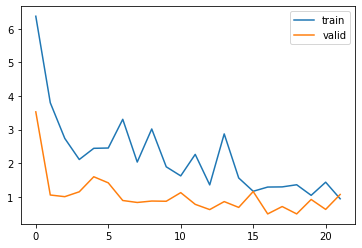

In [81]:
plt.plot(history_6.history['loss'][1:])
plt.plot(history_6.history['val_loss'][1:])
plt.legend(['train', 'valid'])
plt.show();

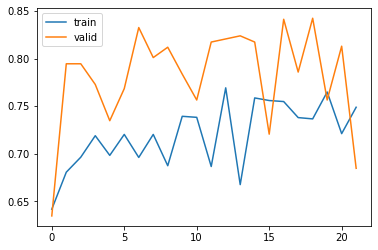

In [82]:
plt.plot(history_6.history['binary_accuracy'][1:])
plt.plot(history_6.history['val_binary_accuracy'][1:])
plt.legend(['train', 'valid'])
plt.show();

### Classification accuracy

In [83]:
x_val_6, y_val_6 = list(tfds.as_numpy(ds_val))[0]
y_pred_6 = model_6.predict(x_val_6)
sum((y_pred_6[:, 0] > 0) == y_val_6) / len(y_val_6)

0.6484375

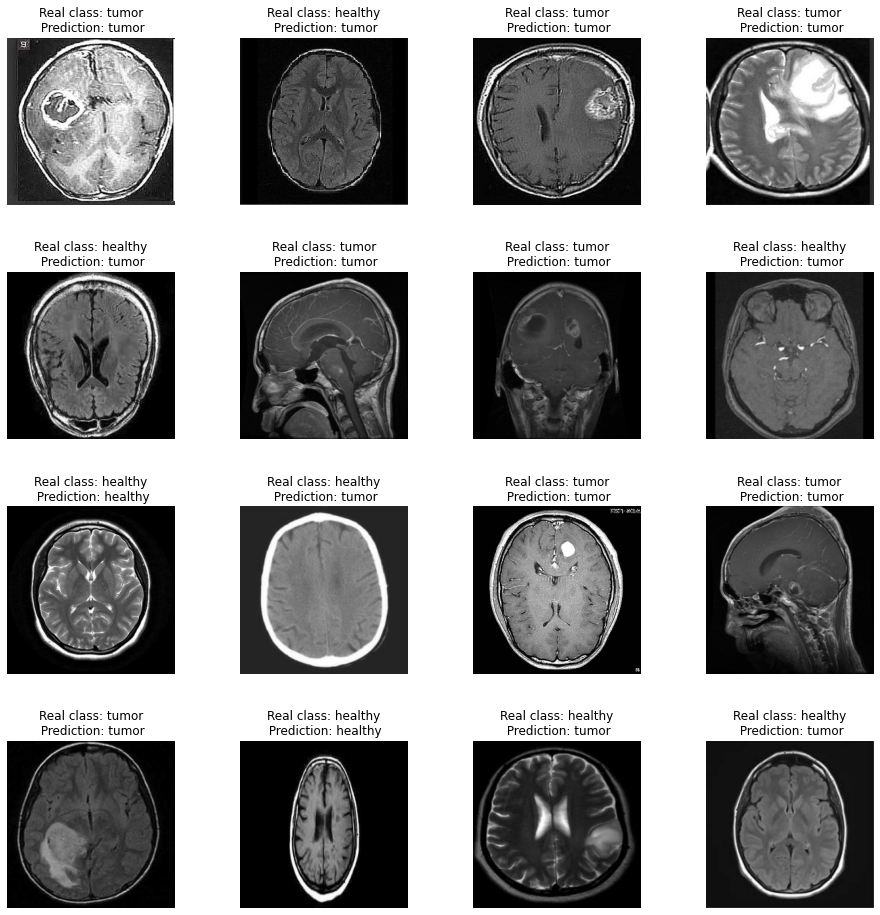

In [84]:
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.4, wspace=.2)

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_val_6[i].astype('int32'))
    
    real_y = 'healthy' if y_val_6[i] == 1 else 'tumor'
    pred_y = 'healthy' if y_pred_6[i] > 0 else 'tumor'
    
    plt.title(f'Real class: {real_y}\n Prediction: {pred_y}')
    plt.axis('off')

plt.show();

In [85]:
y_pred_6_binary = [1 if y > 0 else 0 for y in y_pred_6]

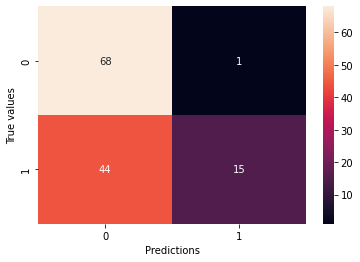

In [86]:
cf = tf.math.confusion_matrix(y_val_6, y_pred_6_binary, dtype=tf.dtypes.int32)
sns.heatmap(cf, annot=True)
plt.xlabel('Predictions')
plt.ylabel('True values')
plt.show();

In [87]:
print(classification_report(y_val_6, y_pred_6_binary, target_names=class_names))

              precision    recall  f1-score   support

 Brain Tumor       0.61      0.99      0.75        69
     Healthy       0.94      0.25      0.40        59

    accuracy                           0.65       128
   macro avg       0.77      0.62      0.58       128
weighted avg       0.76      0.65      0.59       128

